In [1]:
library(NELSI)
library(TreeSim)
library(TreePar)
source('02-Ebola-Functions.R')

Loading required package: ape
Loading required package: geiger
Loading required package: laser
Loading required package: Matrix
Loading required package: subplex
Loading required package: deSolve

Attaching package: ‘deSolve’

The following object is masked from ‘package:graphics’:

    matplot



In [2]:
trees <- read.tree('02-EbolaTrees.trees')

In [3]:
# Skyline
# estimate death rate:
deathfix <- 0
sprobc <- 0.7
# 3 Re intervals
numbRe <- 3

In [4]:
# Calculate likelihood for first 5 trees
numbTree <- 4

In [5]:
likdiff <- vector()
estimates <- c()
for(index in 1:numbTree){
    test <- trees[[index]]
    droptip<-c("EBOV|KM034550|EM095|SierraLeone_EM|2014-05-25","EBOV|KM034554|G3676|SierraLeone_G|2014-05-27","EBOV|KM034559|G3680|SierraLeone_G|2014-05-28","EBOV|KM034563|G3687|SierraLeone_G|2014-05-28","EBOV|KM034561|G3683|SierraLeone_G|2014-05-28","EBOV|KM034562|G3686|SierraLeone_G|2014-05-28")
    test<-drop.tip(test,droptip)
    rootheight<-max(getx(test,sersampling=1)[,1])
    x<-getx(test,sersampling=1)
    times<-x[,1]
    ttype<-x[,2]
    
    if (numbRe == 1){
        out <- optim(c(2, 1, 0.7), LikShiftsSTTebolaConst, times = times, 
                    ttype =ttype, sprobc = sprobc, 
                    deathfix =deathfix, cutoff = 0)
    }else{
       out<-optim(c(rep(2,numbRe),1,0.7),LikShiftsSTTebola,
                  times=times,ttype=ttype,sprobc=sprobc,
                  deathfix=deathfix,cutoff=0)
    }
    estimates <- rbind(estimates, parepi(out, sprobc=sprobc, 
                                        deathfix=deathfix))
}

In [6]:
estimates

1.7939327,1.3311000,0.6782099,4.2882630,0.7000000
1.854099,1.871515,1.628523,6.973842,0.700000
1.5267441,0.7939055,1.0804592,3.2563608,0.7000000
1.5858334,2.0635427,0.5375628,6.4930770,0.7000000


In [7]:
estimatesraw<-estimates

estimatesmedian<-vector()
estimatesHPD<-vector()
estimatesmean<-vector()
estimatesvar<-vector()
for (i in 1:length(estimates[1,])){
    estimatesmedian<-c(estimatesmedian,median(estimates[,i]))
    estimatesHPD<-cbind(estimatesHPD,HPD(estimates[,i]))
    estimatesmean<-c(estimatesmean,mean(estimates[,i]))
    estimatesvar<-c(estimatesvar,var(estimates[,i]))
}

In [8]:
estimates<-round(rbind(estimatesmedian,estimatesHPD,estimatesmean,estimatesvar,estimatesraw),2)
colnames(estimates)<-c("R1","R2","R3","rateUninf","sampProb")
rownames(estimates)<-c("median","95low","95up","mean","var",1:numbTree)
print(estimates)

         R1   R2   R3 rateUninf sampProb
median 1.69 1.60 0.88      5.39      0.7
95low  1.53 1.33 0.54      4.29      0.7
95up   1.79 2.06 1.08      6.97      0.7
mean   1.69 1.52 0.98      5.25      0.7
var    0.03 0.33 0.24      3.14      0.0
1      1.79 1.33 0.68      4.29      0.7
2      1.85 1.87 1.63      6.97      0.7
3      1.53 0.79 1.08      3.26      0.7
4      1.59 2.06 0.54      6.49      0.7


### Question 1. Determine whether 3 Re is better thatn 1 Re

In [36]:
droptip <- c("EBOV|KM034550|EM095|SierraLeone_EM|2014-05-25","EBOV|KM034554|G3676|SierraLeone_G|2014-05-27","EBOV|KM034559|G3680|SierraLeone_G|2014-05-28","EBOV|KM034563|G3687|SierraLeone_G|2014-05-28","EBOV|KM034561|G3683|SierraLeone_G|2014-05-28","EBOV|KM034562|G3686|SierraLeone_G|2014-05-28")
tr <- drop.tip(trees[[1]],droptip)

x <- getx(tr, sersampling = 1)
one_re <- optim(c(2, 1, 0.7), LikShiftsSTTebolaConst, times = x[, 1], ttype = x[, 2], sprobc = sprobc,
               root = 1, deathfix = deathfix, cutoff = 0)

In [37]:
one_re

ERROR: Error in vapply(seq_along(mapped), function(i) {: values must be length 1,
 but FUN(X[[5]]) result is length 0


$par
[1] 122.630957 103.466399  -1.589041

$value
[1] -525.2086

$counts
function gradient 
     144       NA 

$convergence
[1] 0

$message
NULL


In [38]:
three_re <- optim(c(rep(2,numbRe),1,0.7), LikShiftsSTTebola, times = x[, 1], ttype = x[, 2], 
                 sprobc=sprobc, root = 1, deathfix = deathfix, cutoff = 0)

In [39]:
three_re

ERROR: Error in vapply(seq_along(mapped), function(i) {: values must be length 1,
 but FUN(X[[5]]) result is length 0


$par
[1]  152.69246  113.29797   57.72655   85.11605 -231.67219

$value
[1] -526.0343

$counts
function gradient 
     502       NA 

$convergence
[1] 1

$message
NULL


In [43]:
pchisq(2*(one_re$value-three_re$value),2)

[1] 0.5620656

In [71]:
tr <- sim.bdsky.stt(n = 100, lambdasky = c(0.2, 0.5), sampprobsky = c(0.7, 0.5), deathsky = c(0.1, 0.2), timesky = -231, 
                    model = 'SIR', N = 10000, trackinfecteds = T)

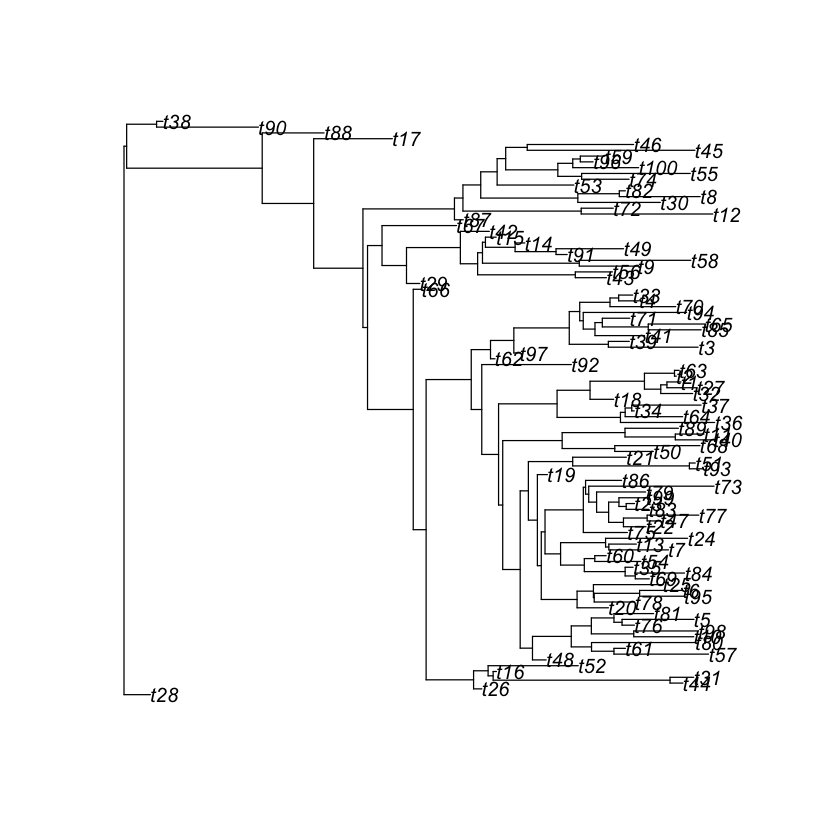

In [72]:
plot(tr[[1]])